In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# Load dataset
file_path = "combined.csv"  # Update this path if needed
df = pd.read_csv(file_path)

In [73]:
# Feature Engineering: Compute LW_RW_DIFF if not already present
if 'LW_RW_DIFF' not in df.columns:
    # Total Fuel in Left and Right Wing
    df['TOTAL_FUEL_LW'] = (df['VALUE_FUEL_QTY_LXT'] + df['VALUE_FUEL_QTY_FT1'] + df['VALUE_FUEL_QTY_FT2'])
    df['TOTAL_FUEL_RW'] = (df['VALUE_FUEL_QTY_RXT'] + df['VALUE_FUEL_QTY_FT3'] + df['VALUE_FUEL_QTY_FT4'])

    # Fuel Difference
    df['LW_RW_DIFF'] = (df['TOTAL_FUEL_LW'] - df['TOTAL_FUEL_RW']).abs()

In [74]:
# Define function to determine leaks
def detect_leak(df, threshold=1500, probability=0.25):
    """
    Function to assign leak labels based on LW_RW_DIFF threshold and probability.
    
    Parameters:
    df (DataFrame): Input dataset
    threshold (int): Fuel difference threshold to consider leak
    probability (float): Probability of assigning a leak when threshold is exceeded
    
    Returns:
    Series: Column with leak labels (0 or 1)
    """
    return np.where((df['LW_RW_DIFF'] > threshold) & (np.random.rand(len(df)) < probability), 1, 0)

In [75]:
# Apply leak detection function
df['LEAK'] = detect_leak(df)

C:\Users\gabri\AppData\Local\Temp\ipykernel_25524\254467267.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='LEAK', data=df, palette='coolwarm')


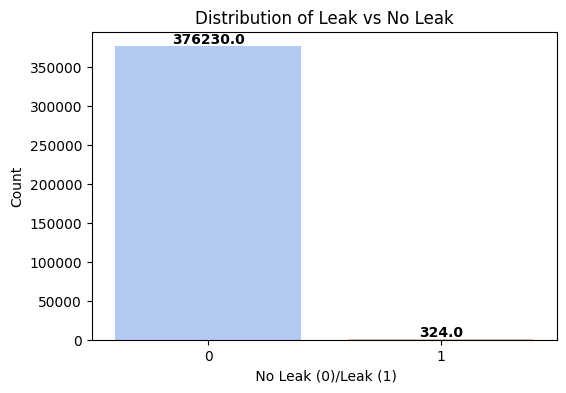

In [76]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(6,4))
ax = sns.countplot(x='LEAK', data=df, palette='coolwarm')
plt.title("Distribution of Leak vs No Leak")
plt.xlabel(" No Leak (0)/Leak (1)")
plt.ylabel("Count")

# Add total values above bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.show()

In [77]:
# Display summary statistics
print("Summary Statistics for LEAK Column:")
print(df['LEAK'].describe())

Summary Statistics for LEAK Column:
count    376554.000000
mean          0.000860
std           0.029321
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: LEAK, dtype: float64


In [78]:
# Display value counts (distribution of leaks vs no leaks with percentages)
leak_counts = df['LEAK'].value_counts()
leak_percentages = df['LEAK'].value_counts(normalize=True) * 100

print(f"\nLeak Distribution at Leak Probability of 30%:")
print(pd.DataFrame({'Count': leak_counts, 'Percentage': leak_percentages.round(2)}))


Leak Distribution at Leak Probability of 30%:
       Count  Percentage
LEAK                    
0     376230       99.91
1        324        0.09


In [79]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376554 entries, 0 to 376553
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   UTC_TIME                   376554 non-null  object 
 1   FUEL_USED_2                376554 non-null  float64
 2   FUEL_USED_3                376554 non-null  float64
 3   FUEL_USED_4                376554 non-null  float64
 4   FW_GEO_ALTITUDE            376554 non-null  float64
 5   VALUE_FOB                  376554 non-null  float64
 6   VALUE_FUEL_QTY_CT          376554 non-null  float64
 7   VALUE_FUEL_QTY_FT1         376554 non-null  float64
 8   VALUE_FUEL_QTY_FT2         376554 non-null  float64
 9   VALUE_FUEL_QTY_FT3         376554 non-null  float64
 10  VALUE_FUEL_QTY_FT4         376554 non-null  float64
 11  VALUE_FUEL_QTY_LXT         376554 non-null  float64
 12  VALUE_FUEL_QTY_RXT         376554 non-null  float64
 13  FLIGHT_PHASE_COUNT         37

In [80]:
# Load an MSN file (change file path as needed)
#msn_file_path = "msn_10_fuel_leak_signals_preprocessed.csv"  # Update with the correct file path
#msn_df = pd.read_csv(msn_file_path,delimiter=";")

# Extract column names from the MSN file
#msn_columns = msn_df.columns.tolist()

# Ensure "LEAK" is included in df
#msn_columns.append("LEAK")

# Filter df to only keep columns that exist in the MSN file + "LEAK"
#df_filtered = df[msn_columns]

# Display the new structure of df
#print(f"Filtered df shape: {df_filtered.shape}")
#print(f"Columns in filtered df: {list(df_filtered.columns)}")

In [81]:
df = df_filtered

## Model Setups

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def split_train_test(df, leak_column="LEAK", test_size=0.15):
    """
    Splits the dataset into train and test sets while maintaining the chronological order.
    Ensures the same proportion of leaks in train and test sets.
    """
    df = df.sort_values(by="UTC_TIME")  # Sort by time to prevent data leakage

    split_idx = int(len(df) * (1 - test_size))  # Compute split index
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]

    # Count the number of leaks in each dataset
    train_leak_count = train_df['LEAK'].sum()
    test_leak_count = test_df['LEAK'].sum()
    total_leak_count = df['LEAK'].sum()
    # Compute expected leak split (should be 75%-25%)
    expected_train_leaks = int(total_leak_count * 0.85)
    expected_test_leaks = total_leak_count - expected_train_leaks

    # Display class distributions
    print(f"Total Leak Count: {total_leak_count}")
    print(f"Train set leak rate: {100 * train_df[leak_column].mean():.4f}% == Training Leak Count: {train_leak_count} (Expected: {expected_train_leaks}) ")
    print(f"Test set leak rate: {100 * test_df[leak_column].mean():.4f}% == Testing Leak Count: {test_leak_count} (Expected: {expected_test_leaks})")
    print(f"Training Data Shape: {train_df.shape}, Testing Data Shape: {test_df.shape}")

    return train_df, test_df

# Apply split
train_df, test_df = split_train_test(df)


Total Leak Count: 291
Train set leak rate: 0.0731% == Training Leak Count: 234 (Expected: 247) 
Test set leak rate: 0.1009% == Testing Leak Count: 57 (Expected: 44)
Training Data Shape: (320070, 18), Testing Data Shape: (56484, 18)


In [90]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

def apply_temporal_smote(df, leak_pct=15, window_size=5):
    """
    Applies Temporal-SMOTE while preserving the temporal order.
    
    Parameters:
    - df: DataFrame containing features and 'LEAK'
    - leak_pct: Target percentage of leaks after resampling
    - window_size: Number of past time steps to use when generating synthetic leaks
    
    Returns:
    - X_train_resampled: Feature matrix after Temporal-SMOTE
    - y_train_resampled: Target variable after Temporal-SMOTE
    """
    # Drop non-relevant categorical columns but keep UTC_TIME for sorting
    drop_columns = ["FLIGHT_ID", "MSN"]  # Drop only flight-specific info
    df_filtered = df.drop(columns=drop_columns, errors="ignore")

    # Extract features and target
    X_train = df_filtered.drop(columns=["LEAK"], errors="ignore")  # Keep UTC_TIME for sorting
    y_train = df_filtered["LEAK"]

    # Convert UTC_TIME to datetime if it's not already
    X_train["UTC_TIME"] = pd.to_datetime(X_train["UTC_TIME"])

    # Sort data by UTC_TIME before resampling
    X_train_sorted = X_train.sort_values(by="UTC_TIME")
    y_train_sorted = y_train.loc[X_train_sorted.index]  # Ensure labels align

    leak_prop = leak_pct / 100  
    leak_count = sum(y_train_sorted == 1)
    non_leak_count = sum(y_train_sorted == 0)

    # Compute the target number of leak samples (ensuring it does not exceed available non-leak samples)
    target_leak_count = min((non_leak_count * leak_prop) / (1 - leak_prop), non_leak_count)

    # **Fix:** Compute a valid `sampling_strategy` within SMOTE's limits
    if leak_count == 0:  # Avoid division by zero
        print("Warning: No leaks available for SMOTE.")
        return X_train_sorted, y_train_sorted
    
    smote_ratio = max(min(target_leak_count / leak_count, 1.0), 0.01)  # Keep between 0.01 and 1.0

    print(f"Original leak percentage: {100 * leak_count / (leak_count + non_leak_count):.4f}%")
    print(f"Target leak percentage: {leak_pct}%")
    print(f"Applying Temporal-SMOTE with adjusted ratio: {smote_ratio:.3f}")

    # Apply rolling window to generate synthetic leaks using only past data
    X_resampled = []
    y_resampled = []
    
    for i in range(len(X_train_sorted) - window_size):
        X_window = X_train_sorted.iloc[i : i + window_size]  # Select past `window_size` samples
        y_window = y_train_sorted.iloc[i : i + window_size]  # Corresponding labels

        # Check the number of leak cases in the window
        leaks_in_window = sum(y_window)

        # **Fix: Skip SMOTE if there are fewer than 3 leaks (avoid small sample errors)**
        if leaks_in_window < 3:
            X_resampled.append(X_window)
            y_resampled.append(y_window)
            continue

        # Dynamically adjust `k_neighbors` based on available leak cases
        k_neighbors = min(3, max(1, leaks_in_window - 1))  # Ensure k_neighbors <= n_samples_fit - 1

        # Initialize SMOTE with valid k_neighbors
        smote = SMOTE(sampling_strategy=smote_ratio, random_state=0, k_neighbors=k_neighbors)

        try:
            # Apply SMOTE on the window, excluding UTC_TIME
            X_synthetic, y_synthetic = smote.fit_resample(X_window.drop(columns=["UTC_TIME"]), y_window)
        except ValueError as e:
            print(f"Skipping SMOTE on this window due to insufficient samples. Error: {e}")
            X_resampled.append(X_window)
            y_resampled.append(y_window)
            continue

        # **Fix: Convert timestamps to numeric for interpolation**
        num_synthetic_samples = len(X_synthetic) - len(X_window)

        if num_synthetic_samples > 0:
            last_timestamp = X_window["UTC_TIME"].values[-1]  # Get last known timestamp
            last_timestamp_numeric = last_timestamp.astype('datetime64[ns]').astype(np.int64)  # Convert to numeric

            synthetic_timestamps_numeric = np.linspace(
                last_timestamp_numeric, 
                last_timestamp_numeric + (num_synthetic_samples * 1000000000),  # Add 1 second per sample
                num_synthetic_samples
            )

            # Convert timestamps back to datetime
            synthetic_timestamps = pd.to_datetime(synthetic_timestamps_numeric)

            # Append new timestamps to the synthetic samples
            X_synthetic = X_synthetic.assign(UTC_TIME=np.concatenate([X_window["UTC_TIME"].values, synthetic_timestamps]))

        X_resampled.append(X_synthetic)
        y_resampled.append(y_synthetic)

    # Concatenate all resampled windows into a new DataFrame
    X_train_resampled = pd.concat(X_resampled)
    y_train_resampled = pd.concat(y_resampled)

    # Ensure the final dataset is still sorted by time
    X_train_resampled = X_train_resampled.sort_values(by="UTC_TIME")
    y_train_resampled = y_train_resampled.loc[X_train_resampled.index]

    # Display new distribution
    print("Target variable distribution after Temporal-SMOTE resampling:")
    print(y_train_resampled.value_counts(normalize=True) * 100)

    return X_train_resampled, y_train_resampled

# Apply Temporal-SMOTE on the training data
X_train_resampled, y_train_resampled = apply_temporal_smote(train_df, leak_pct=15, window_size=5)


Original leak percentage: 0.0731%
Target leak percentage: 15%
Applying Temporal-SMOTE with adjusted ratio: 1.000
Skipping SMOTE on this window due to insufficient samples. Error: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 2, n_samples = 2
Skipping SMOTE on this window due to insufficient samples. Error: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 2, n_samples = 2
Skipping SMOTE on this window due to insufficient samples. Error: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 2, n_samples = 2
Skipping SMOTE on this window due to insufficient samples. Error: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 2, n_samples = 2
Skipping SMOTE on this window due to insufficient samples. Error: Expected n_neighbors <= n_samples_fit, but n_neighbors = 4, n_samples_fit = 1, n_samples = 1
Skipping SMOTE on this window due to insufficient samples. Error: Expected n_neighbors <= n_

In [91]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def apply_pca(X_train, X_test, n_components=15):
    """
    Applies PCA transformation on training and test sets, keeping the top 'n_components'.
    """
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"PCA applied: reduced to {n_components} features.")
    
    return X_train_pca, X_test_pca

# Extract test features
X_test = test_df.drop(columns=drop_columns, errors="ignore")
y_test = test_df["LEAK"]

# Apply PCA
X_train_pca, X_test_pca = apply_pca(X_train, X_test)


PCA applied: reduced to 15 features.


In [92]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


def train_autoencoder(X_train, encoding_dim=10):
    """
    Trains an Autoencoder for anomaly detection with improved regularization.
    """
    input_dim = X_train.shape[1]

    # Define Autoencoder model
    input_layer = Input(shape=(input_dim,))
    
    # Encoder with L1 & L2 regularization + Dropout
    encoder = Dense(encoding_dim, activation="relu", 
                    activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=10e-4))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
    encoder = Dropout(0.2)(encoder)  # Dropout to prevent overfitting
    
    # Decoder with same structure
    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping with longer patience
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Train Autoencoder
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=32,
        shuffle=False,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    return autoencoder

# Train the Autoencoder
autoencoder = train_autoencoder(X_train_pca)

# Get reconstruction loss on test data
reconstructions = autoencoder.predict(X_test_pca)
mse = np.mean(np.power(X_test_pca - reconstructions, 2), axis=1)

# Determine the threshold for anomaly detection (95th percentile of MSE)
threshold = np.percentile(mse, 95)

# Classify anomalies
test_df = test_df.copy()  # Prevent SettingWithCopyWarning
test_df.loc[:, "reconstruction_error"] = mse
test_df.loc[:, "anomaly"] = test_df["reconstruction_error"] > threshold

# Evaluate Model Performance
y_pred = test_df["anomaly"].astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Print evaluation results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0287 - val_loss: 0.0149
Epoch 2/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0228 - val_loss: 0.0137
Epoch 3/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0220 - val_loss: 0.0132
Epoch 4/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0212 - val_loss: 0.0131
Epoch 5/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0207 - val_loss: 0.0144
Epoch 6/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0207 - val_loss: 0.0140
Epoch 7/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 0.0205 - val_loss: 0.0138
Epoch 8/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0205 - val_loss: 0.0137
Epoch 9/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.0204 - val_loss: 0.0135
Epoch 10/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 0.0204 - val_loss: 0.0138
Epoch 11/50
8002/8002 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0207 - val_loss: 0.0133
Epoch 12/50
8002/80